In [1]:
import pandas as pd
from pathlib import Path
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from statsmodels.stats.multitest import multipletests

In [2]:
# PARAMETERS
run_id="DMRs.07.23.ldcts"

In [3]:
# Parameters
run_id = "subclass_loops.09.19.ldcts"


In [4]:
ldsc_results=f'/anvil/projects/x-mcb130189/rwang22/bican/ldsc/output/{run_id}'
directory = Path(ldsc_results)
dfs = {}

for file in directory.glob(f'*.cell_type_results.txt'):
    cur = pd.read_csv(file, sep = "\t")
    stripped = file.stem.replace(f'_.cell_type_results', "")
    cur["Trait"] = stripped
    dfs[stripped] = cur

In [5]:
combined_df = pd.concat(dfs.values(), ignore_index=True)
combined_df["-log10(pval)"] = -np.log10(combined_df["Coefficient_P_value"])
combined_df["Trait"] = combined_df["Trait"].str.replace(f'{run_id}.cell_type_results', "")
combined_df.head()

/tmp/ipykernel_1752565/1445883874.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  combined_df["Trait"] = combined_df["Trait"].str.replace(f'{run_id}.cell_type_results', "")


,Name,Coefficient,Coefficient_std_error,Coefficient_P_value,Trait,-log10(pval)
0,STR_RSPO2_GABA,6.548642e-09,1.178553e-09,1.376115e-08,Mullins.NatGenet.2021.Bipolar_Disorder_,7.861345
1,STR_D2_MSN,6.631100e-09,1.226376e-09,3.203227e-08,Mullins.NatGenet.2021.Bipolar_Disorder_,7.494412
2,ACx_MEIS2_GABA,1.221990e-08,2.374966e-09,1.335519e-07,Mullins.NatGenet.2021.Bipolar_Disorder_,6.874350
3,STR_D1_MSN,6.044823e-09,1.219395e-09,3.575264e-07,Mullins.NatGenet.2021.Bipolar_Disorder_,6.446692
4,Glut,6.036109e-09,1.231740e-09,4.780299e-07,Mullins.NatGenet.2021.Bipolar_Disorder_,6.320545


In [6]:
# Perform FDR correction using Benjamini-Hochberg procedure
rejected, q_values, _, _ = multipletests(combined_df["Coefficient_P_value"], alpha=0.05, method='fdr_bh')
combined_df["FDR_BH_corrected"] = q_values

In [7]:
# calculate the FDR p value threshold 
# https://www.r-bloggers.com/2023/07/the-benjamini-hochberg-procedure-fdr-and-p-value-adjusted-explained/

def fdr_bh_adj(df):
    tmp = combined_df.copy()
    tmp["rank"] =  combined_df['Coefficient_P_value'].rank()
    num_tests = len(tmp)
    tmp["adj_pval"] = (num_tests * tmp["Coefficient_P_value"]) / tmp["rank"]

    return tmp


In [8]:
tmp = fdr_bh_adj(combined_df)
# Align indices before comparison
fdr_bh_corrected = combined_df["FDR_BH_corrected"]
adj_pval = tmp["adj_pval"]

print(fdr_bh_corrected.sort_values())

960     0.000001
2816    0.000001
961     0.000003
2817    0.000003
1952    0.000003
          ...   
1616    0.999996
1617    0.999996
1618    0.999996
1644    0.999996
3903    0.999996
Name: FDR_BH_corrected, Length: 3904, dtype: float64


In [9]:
print(adj_pval.sort_values())

960     0.000001
2816    0.000001
1952    0.000003
961     0.000004
608     0.000004
          ...   
2159    1.130774
3893    1.130966
3838    1.131157
2158    1.131375
2811    1.131457
Name: adj_pval, Length: 3904, dtype: float64


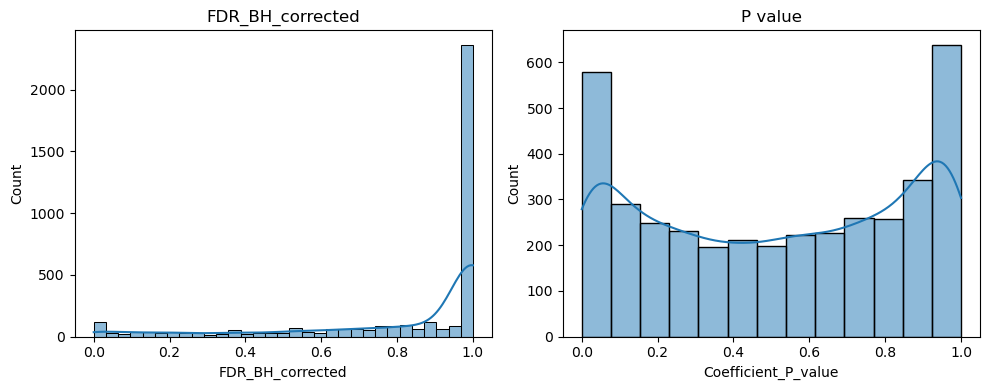

In [10]:
# plot the distribution of p values 
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# First plot
sns.histplot(combined_df["FDR_BH_corrected"], kde=True, ax=axes[0])
axes[0].set_title("FDR_BH_corrected")

# Second plot
sns.histplot(combined_df["Coefficient_P_value"], kde=True, ax=axes[1])
axes[1].set_title("P value")

plt.tight_layout()
plt.show()

In [11]:
modified_df = combined_df.drop(['Coefficient', 'Coefficient_std_error', 'Coefficient_P_value', 'FDR_BH_corrected'], axis=1)
modified_df = modified_df.pivot(index="Name", columns="Trait", values="-log10(pval)").reset_index()
modified_df = modified_df.set_index("Name")
modified_df.head()

Trait,Arvanitis.NatCommun.2019.Heart_Failure_,Astle.Cell.2016.Basophil_count_,Astle.Cell.2016.Eosinophil_count_,Astle.Cell.2016.Lymphocyte_count_,Astle.Cell.2016.Monocyte_count_,Astle.Cell.2016.Neutrophil_count_,Aylward.2018.biorxiv.Type_1_Diabetes_,Barban.NatGenet.2016.Age_First_Birth_,Barban.NatGenet.2016.Number_Children_Born_,Bellenguez.NatGenet.2022.Alzheimers_Disease_Dementia_,...,Yengo.biorxiv.2018.BMI_,Yengo.biorxiv.2018.Height_,Zhu.RespirRes.2019.Hypertension_,deLange.NatGenet.2017.Crohns_Disease_,deLange.NatGenet.2017.Inflammatory_Bowel_Disease_,deLange.NatGenet.2017.Ulcerative_Colitis_,denHoed.NatGenet.2013.Heart_Rate_,vanRheenen.NatGenet.2016.Amyotrophic_Lateral_Sclerosis_,vandenBerg.BehavGenet.2016.Extraversion_,vanderValk.HumMolGenet.2014.Birth_Length_
Name,,,,,,,,,,,,,,,,,,,,,
ACx_MEIS2_GABA,0.019068,0.208455,0.000338,0.151718,0.011445,0.030365,0.342840,1.956307,0.419286,0.049203,...,1.016610,0.006043,0.003632,0.000889,0.000002,0.000003,0.448545,0.507989,0.489236,0.465102
Astrocyte,0.228918,0.047963,0.034157,0.163131,0.002371,0.035908,0.047024,0.049720,0.595758,0.026312,...,1.756708,1.882760,0.025697,0.003994,0.000583,0.002868,0.883104,0.175602,0.267013,0.472368
CN_Cholinergic_GABA,0.112957,0.049115,0.039988,0.007407,0.000072,0.009314,0.011801,0.401354,0.586879,0.495111,...,0.492304,0.024441,0.012060,0.008534,0.000512,0.001355,1.773206,0.166602,0.080568,0.292309
CN_GABA-Glut,0.536832,0.432936,0.002552,0.029861,0.000403,0.012132,0.415700,0.306933,0.554079,0.298366,...,1.138063,0.032063,0.006381,0.015964,0.029102,0.194871,0.244417,0.119103,0.062246,0.695546
CN_LAMP5-CXCL14_GABA,0.197790,0.011569,0.066850,0.134655,0.000814,0.000317,0.056683,0.568753,0.214232,0.808553,...,2.058347,0.006488,0.001310,0.002860,0.004678,0.002872,0.497694,0.262691,0.592453,1.256997


In [12]:
fdr_modified_df = combined_df.drop(['Coefficient', 'Coefficient_std_error', 'Coefficient_P_value', '-log10(pval)'], axis=1)
fdr_modified_df = fdr_modified_df.pivot(index="Name", columns="Trait", values="FDR_BH_corrected").reset_index()
fdr_modified_df = fdr_modified_df.set_index("Name")
fdr_modified_df.head()

Trait,Arvanitis.NatCommun.2019.Heart_Failure_,Astle.Cell.2016.Basophil_count_,Astle.Cell.2016.Eosinophil_count_,Astle.Cell.2016.Lymphocyte_count_,Astle.Cell.2016.Monocyte_count_,Astle.Cell.2016.Neutrophil_count_,Aylward.2018.biorxiv.Type_1_Diabetes_,Barban.NatGenet.2016.Age_First_Birth_,Barban.NatGenet.2016.Number_Children_Born_,Bellenguez.NatGenet.2022.Alzheimers_Disease_Dementia_,...,Yengo.biorxiv.2018.BMI_,Yengo.biorxiv.2018.Height_,Zhu.RespirRes.2019.Hypertension_,deLange.NatGenet.2017.Crohns_Disease_,deLange.NatGenet.2017.Inflammatory_Bowel_Disease_,deLange.NatGenet.2017.Ulcerative_Colitis_,denHoed.NatGenet.2013.Heart_Rate_,vanRheenen.NatGenet.2016.Amyotrophic_Lateral_Sclerosis_,vandenBerg.BehavGenet.2016.Extraversion_,vanderValk.HumMolGenet.2014.Birth_Length_
Name,,,,,,,,,,,,,,,,,,,,,
ACx_MEIS2_GABA,0.999996,0.999996,0.999996,0.999996,0.999996,0.999996,0.999996,0.172000,0.966647,0.999996,...,0.567599,0.999996,0.999996,0.999996,0.999996,0.999996,0.939927,0.891630,0.905247,0.926299
Astrocyte,0.999996,0.999996,0.999996,0.999996,0.999996,0.999996,0.999996,0.999996,0.833558,0.999996,...,0.221948,0.189403,0.999996,0.999996,0.999996,0.999996,0.646271,0.999996,0.999996,0.921200
CN_Cholinergic_GABA,0.999996,0.999996,0.999996,0.999996,0.999996,0.999996,0.999996,0.980179,0.835305,0.898870,...,0.902747,0.999996,0.999996,0.999996,0.999996,0.999996,0.216486,0.999996,0.999996,0.999996
CN_GABA-Glut,0.877162,0.953561,0.999996,0.999996,0.999996,0.999996,0.968811,0.999996,0.862350,0.999996,...,0.502746,0.999996,0.999996,0.999996,0.999996,0.999996,0.999996,0.999996,0.999996,0.766672
CN_LAMP5-CXCL14_GABA,0.999996,0.999996,0.999996,0.999996,0.999996,0.999996,0.999996,0.850246,0.999996,0.693345,...,0.147359,0.999996,0.999996,0.999996,0.999996,0.999996,0.898735,0.999996,0.833684,0.435543


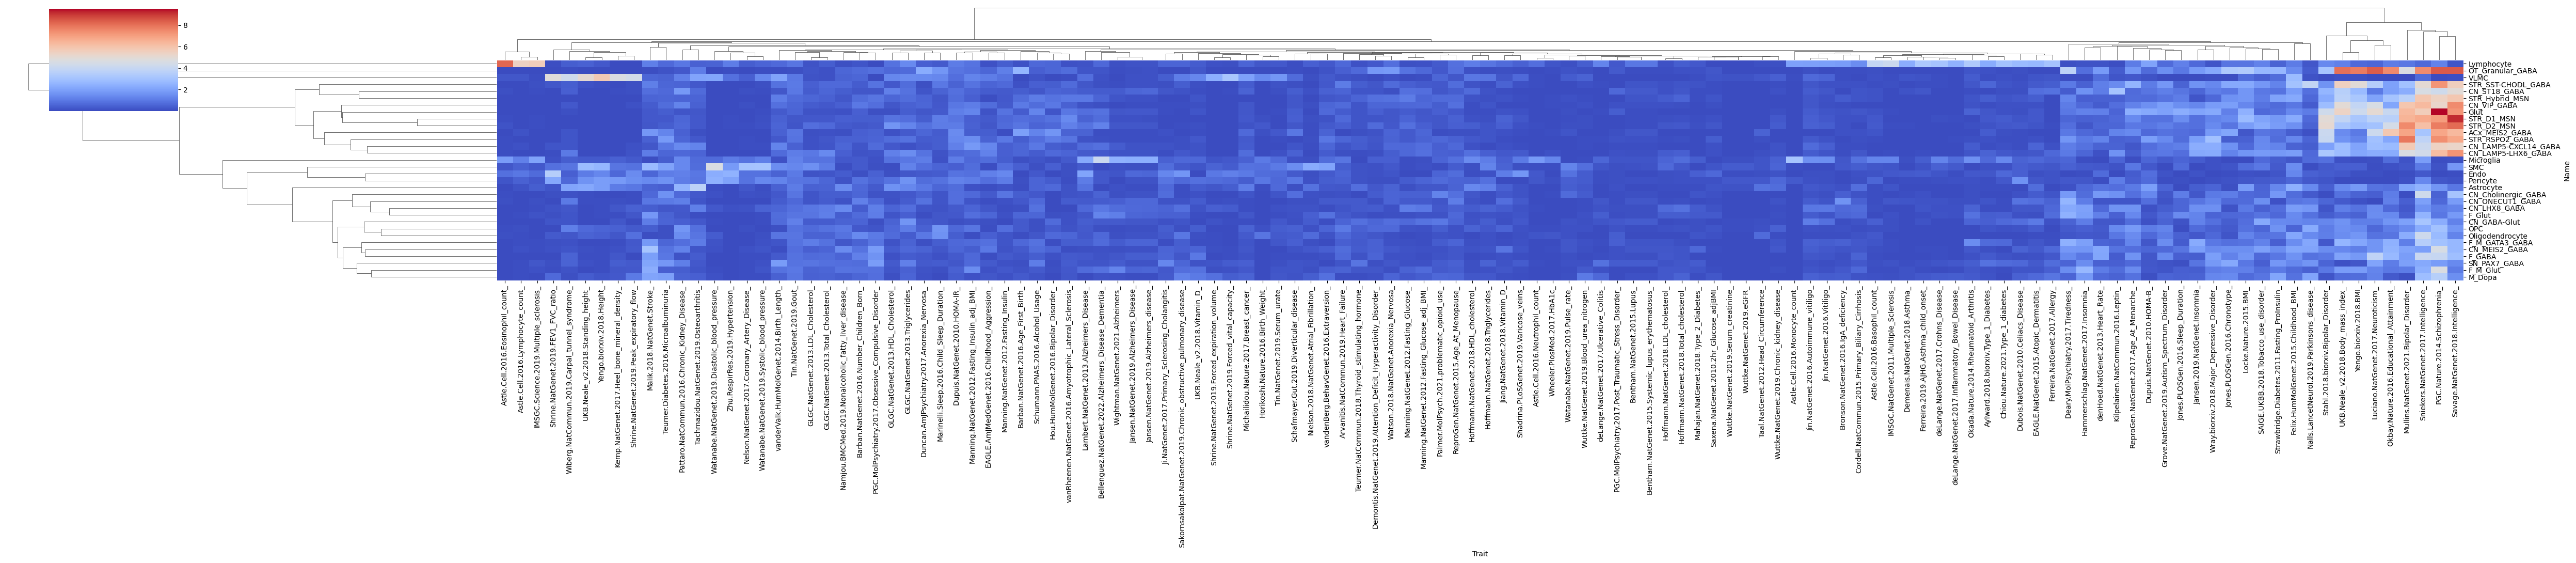

In [13]:
g = sns.clustermap(modified_df, cmap='coolwarm', figsize=(50, 11))

plt.show()
g.savefig(f'output/{run_id}.pdf')

In [14]:
def pval_to_star(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

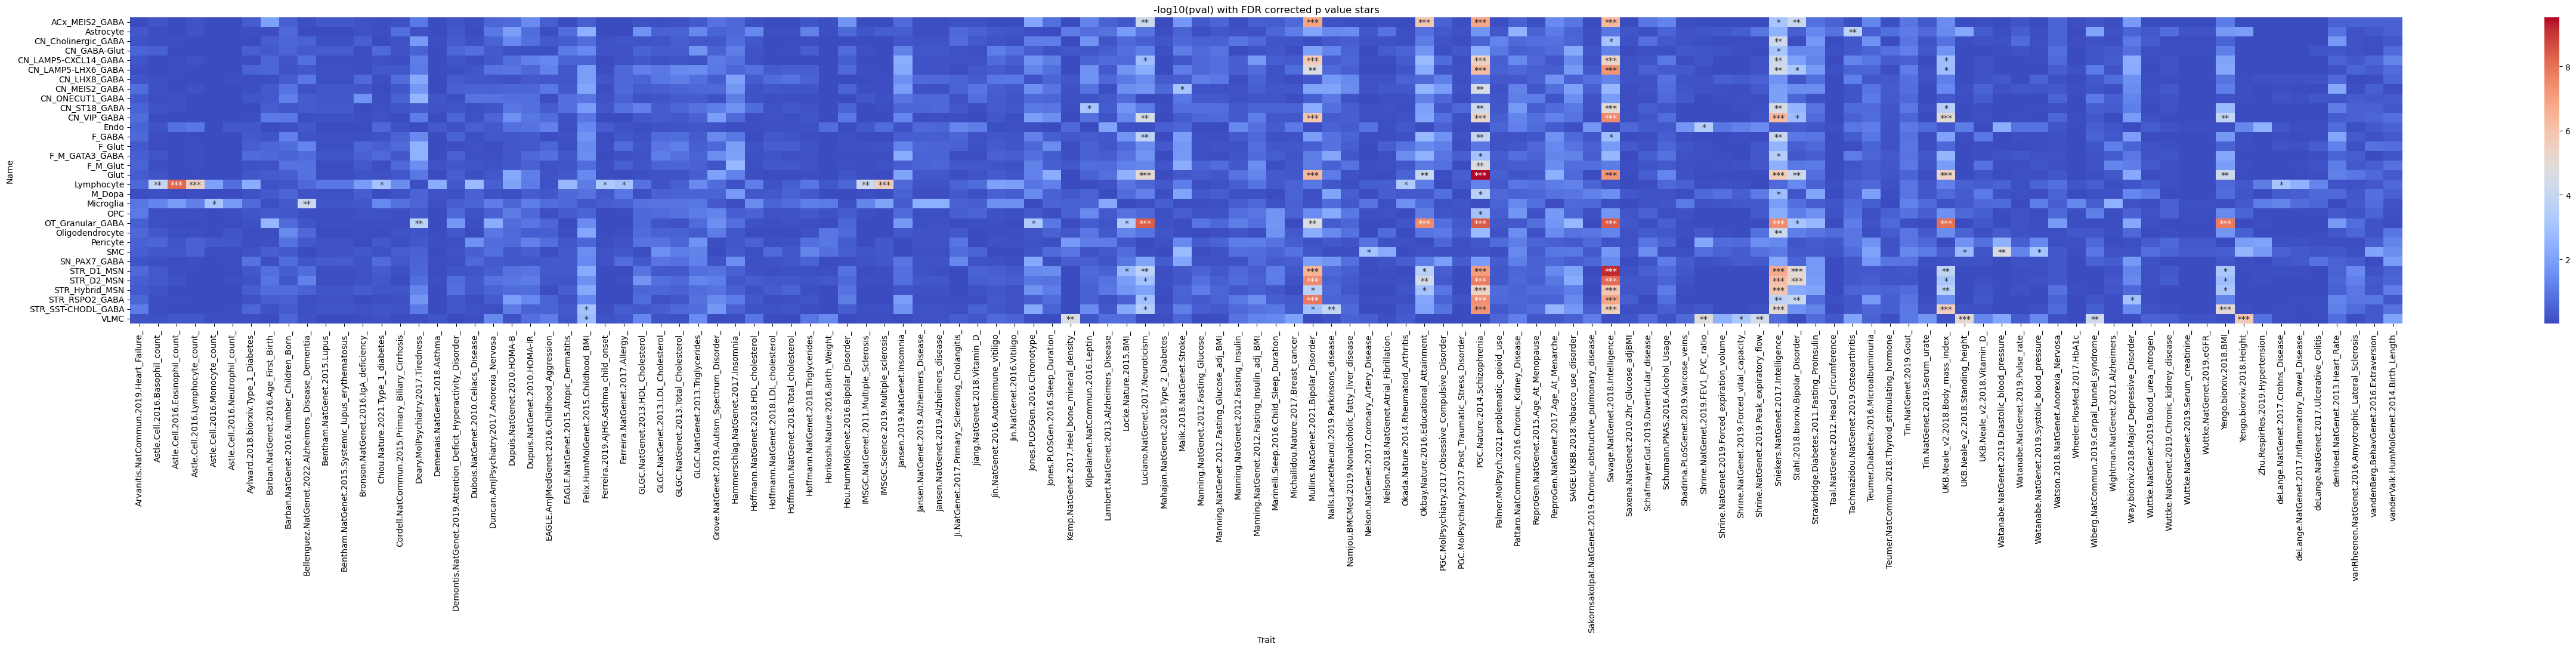

In [15]:
stars = fdr_modified_df.applymap(pval_to_star)

# Plot heatmap with annotations
plt.figure(figsize=(50, 11))
sns.heatmap(modified_df, annot=stars, fmt='', cmap='coolwarm')
plt.title("-log10(pval) with FDR corrected p value stars")
plt.tight_layout()
plt.savefig(f'output/{run_id}_FDR_corrected.pdf')
plt.show()

